# Principal Component Analysis of Happiness

We've seen from the EDA that our happiness score statistic is split into many subcategories. We'd like to be able to visualize this, but since there are so many, it's hard. One solution to this is to perform Principal Component Analysis. PCA allows us to get summarized data by projecting data onto vectors explaining the most variation in the data. Hopefully, we'll be able to analyze the results to find important features for separating scores.

## Import/setup
We'll need some outside libraries, let's import them.

In [1]:
import pandas as pd
import numpy as np
from dataset import *
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score


Gather the consistent, yearly dataset.

In [2]:
df = get_consistent_yearly()
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Country or region             1230 non-null   object
 1   Overall rank                  1230 non-null   int64 
 2   Score                         1230 non-null   object
 3   GDP per capita                1230 non-null   object
 4   Social support                1230 non-null   object
 5   Healthy life expectancy       1230 non-null   object
 6   Freedom to make life choices  1230 non-null   object
 7   Perceptions of corruption     1229 non-null   object
 8   Generosity                    1230 non-null   object
 9   year                          1230 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 96.2+ KB
None


Country or region  Overall rank  Score GDP per capita Social support  \
0       Switzerland             1  7.587        1.39651        1.34951   
1           Iceland             2  7.561        1.30232        1.40223   
2           Denmark             3  7.527        1.32548        1.36058   
3            Norway             4  7.522          1.459        1.33095   
4            Canada             5  7.427        1.32629        1.32261   

  Healthy life expectancy Freedom to make life choices  \
0                 0.94143                      0.66557   
1                 0.94784                      0.62877   
2                 0.87464                      0.64938   
3                 0.88521                      0.66973   
4                 0.90563                      0.63297   

  Perceptions of corruption Generosity  year  
0                   0.41978    0.29678  2015  
1                   0.14145     0.4363  2015  
2                   0.48357    0.34139  2015  
3                   0.36503    0.34699  2015  
4                   0.32957    0.45811  2015

We get the 1230 data rows that we normally expect. So we have 1230 countries over 8 years. Now, we need to set the correct types for each feature.

In [3]:
cat = ["Country or region", "Overall rank", "year"]
num = list(set(df.columns)-set(cat))
for col in num:
    df[col] = df[col].astype(str).str.replace(',','.')
df[cat] = df[cat].astype("category")
df[num] = df[num].astype("float64")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Country or region             1230 non-null   category
 1   Overall rank                  1230 non-null   category
 2   Score                         1230 non-null   float64 
 3   GDP per capita                1230 non-null   float64 
 4   Social support                1230 non-null   float64 
 5   Healthy life expectancy       1230 non-null   float64 
 6   Freedom to make life choices  1230 non-null   float64 
 7   Perceptions of corruption     1229 non-null   float64 
 8   Generosity                    1230 non-null   float64 
 9   year                          1230 non-null   category
dtypes: category(3), float64(7)
memory usage: 84.7 KB


Having the features cast to their correct data type allows for us to perform some good analysis on them.
We still have one null value, so let's remove it.

In [4]:
df = df.dropna()

## Let's do some PCA!

Hopefully summarizing the data will help us to find trends in the data we can predict on. 
The first step to this is to make the SVD transformer to get some principle components.

In [5]:
svd = TruncatedSVD(n_components=3, random_state=42) # the random state sets the starting seed for consistent resultsb

Next, we need to define our data. We want to be predicting the score, so we should take all the non-score features as our X matrix.

In [6]:
X = df[['GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Perceptions of corruption',
       'Generosity']]
y = df['Score']

Now that we have the projector and the data defined, we need to actually project our data and try to summarize it into 3 components.

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_proj = svd.fit_transform(X_scaled)
X_proj.shape

(1229, 3)

How effective are these components in summarizing our data?

Text(0, 0.5, 'Explained Variance Ratio')

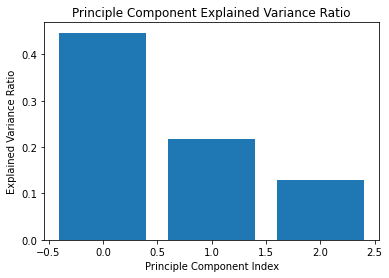

In [8]:
plt.bar(range(len(svd.explained_variance_ratio_)), svd.explained_variance_ratio_)
plt.title("Principle Component Explained Variance Ratio")
plt.xlabel("Principle Component Index")
plt.ylabel("Explained Variance Ratio")

With about 45% for the first component, and around 20% for the second component, it's fairly good at explaining the data. At least, we get roughly 65% of the data described.

What are the components?

In [9]:
svd.components_

array([[-0.50699966, -0.44541456, -0.51375081, -0.4079362 , -0.33289435,
        -0.05819562],
       [-0.22240776, -0.24527548, -0.23008848,  0.33293951,  0.49236821,
         0.69581524],
       [ 0.18153881, -0.48957804, -0.17831988,  0.2141942 ,  0.50159279,
        -0.63093941]])

These are just numbers right now. Let's give these components some context.

In [10]:
for i in range(3):
    print("Component",i)
    for col, comp in zip(X.columns, svd.components_[i]):
        print("\t", col, comp)
    

Component 0
	 GDP per capita -0.5069996648784661
	 Social support -0.44541456206428226
	 Healthy life expectancy -0.5137508061665207
	 Freedom to make life choices -0.40793619653189817
	 Perceptions of corruption -0.3328943463241823
	 Generosity -0.05819562373531832
Component 1
	 GDP per capita -0.2224077581039728
	 Social support -0.2452754827103283
	 Healthy life expectancy -0.23008847816962508
	 Freedom to make life choices 0.33293950554142654
	 Perceptions of corruption 0.4923682124692243
	 Generosity 0.695815239794054
Component 2
	 GDP per capita 0.18153880969105518
	 Social support -0.4895780420222598
	 Healthy life expectancy -0.1783198840989057
	 Freedom to make life choices 0.21419419832050982
	 Perceptions of corruption 0.5015927891442272
	 Generosity -0.6309394103754391


Evidently, the first component doesn't care too much for generosity, but the second component uses generosity heavily. The inverse is true for GDP per capita and Healthy Life Expectancy, as they have large values for the first component and significantly lower weights for the second. Otherwise, it's interesting to see how many of the components are negative.

Of course, This is this is just analysing the components. How does the data actually look projected?

Text(0, 0.5, 'Second Principle Component')

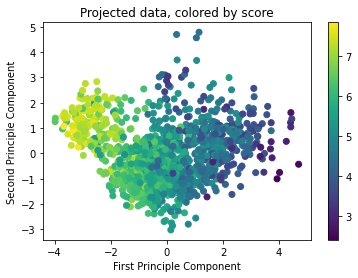

In [11]:
fig = plt.scatter(X_proj[:, 0], X_proj[:, 1], c=y)
plt.colorbar(fig)
plt.title("Projected data, colored by score")
plt.xlabel("First Principle Component")
plt.ylabel("Second Principle Component")

We can see a general trend in our projected data. As the points travel to the right, they get a progressively lower score. This explains some of our earlier observations of the component trends. The negative weights push the data to the left, so they have a higher importance. In general, the largest negative weights in the first component were for the `Healthy Life Expectancy` and the `GDP per capita`. This indicates that these two features are likely large descriptors of the data, that their values have high impact on their score.

Now that we've seen the data, let's write some functions to help us with splitting the PCA data into bins for predictions.

First, we need to be able to plot each of the divided sections up from the score. 

In [12]:
def plot_divisions(X_proj, y, divs):
    fig,axes = plt.subplots(divs)
    fig.set_size_inches(10,10)
    previous = min(y)
    mask = y == -1 # temp all False
    for i, ax in zip(reversed(np.linspace(max(y), min(y), divs, endpoint=False)), axes):
        i = round(i, 3)
        cur = (y<i)&(~mask)
        mask = y<i
        ax.scatter(X_proj[cur, 0], X_proj[cur, 1])
        ax.set_xlim(X_proj[:,0].min(), X_proj[:,0].max())
        ax.set_ylim(X_proj[:,1].min(), X_proj[:,1].max())
        ax.set_title("Projected data for scores: " + str(previous) + " to " + str(i))
        ax.set_xlabel("First Principle Component")
        ax.set_ylabel("Second Principle Component")
        ax.set_xlim(X_proj[:,0].min(), X_proj[:,0].max())
        ax.set_ylim(X_proj[:,1].min(), X_proj[:,1].max())
        previous = i
    plt.show()

Now, let's combine it and plot one PCA graph with all the divided sections on one graph.

In [13]:
def plot_with_division(X_proj, y, divs):
    mask = y == -1 # temp all False
    previous = min(y)
    for i in reversed(np.linspace(max(y), min(y), divs, endpoint=False)):
        i = round(i, 3)
        cur = (y<i)&(~mask)
        mask = y<i
        plt.scatter(X_proj[cur, 0], X_proj[cur, 1], label=str(previous) + " to " + str(i))
        previous = i
    plt.title("Projected data")
    plt.xlabel("First Principle Component")
    plt.ylabel("Second Principle Component")
    plt.xlim(X_proj[:,0].min(), X_proj[:,0].max())
    plt.ylim(X_proj[:,1].min(), X_proj[:,1].max())
    plt.legend()
    plt.show()

Now that we have them, let's try it on a few divisions.

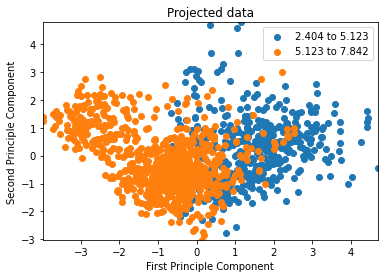

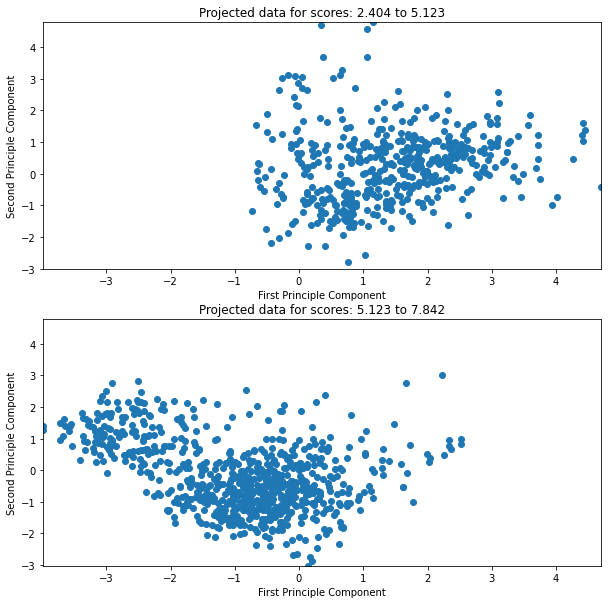

In [14]:
plot_with_division(X_proj, y, 2)
plot_divisions(X_proj, y, 2)

Based on the graphs above, our functions seem to be working well! Also, these look like they might be separable, so that gives good hopes for clustering!

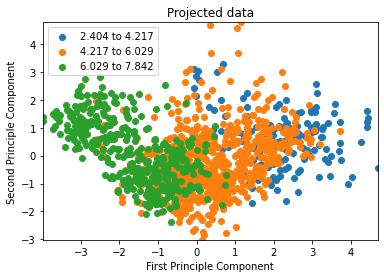

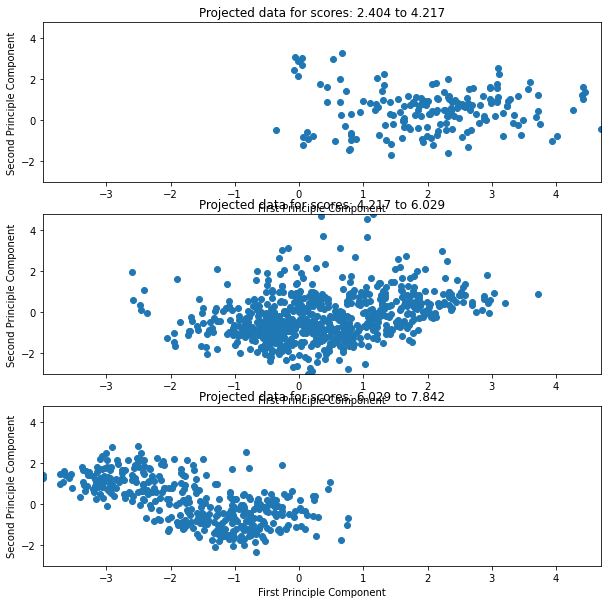

In [15]:
plot_with_division(X_proj, y, 3)
plot_divisions(X_proj, y, 3)

As we increase our size, some of the clusters get smaller, and there always seems to be some overlap. It won't be a perfect division, but it's still a decently consistent split. For 3 groups, for example, we have the upper scores on the left, the lowest scores on the right, and the median scores in the middle.

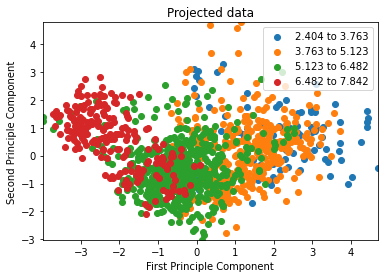

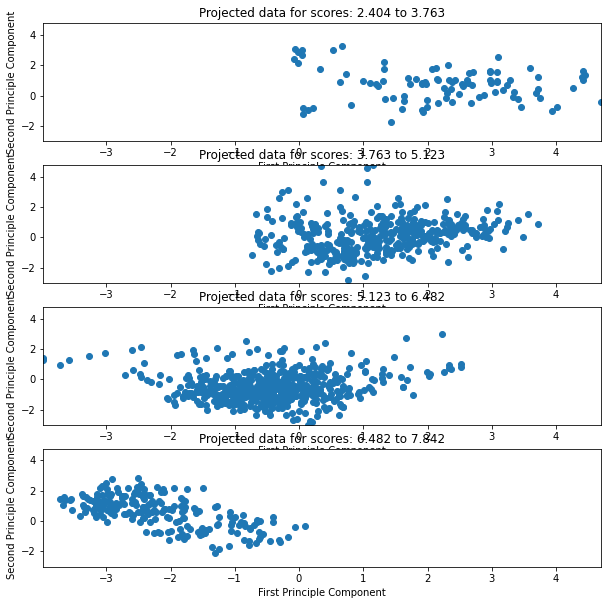

In [16]:
plot_with_division(X_proj, y, 4)
plot_divisions(X_proj, y, 4)

4 divisions is the most splits until it starts to get too detailed in divisions. If we increase more we'll likely have too much overlap for clustering to get good results.Overall I like the splits for 4, even if they still have some overlap.

## Clustering

We need an algorithm that won't cluster the entire piece. DBSCAN would likely cluster most of it together because of it's uniform density. Instead, we can use an algorithm like k-means to split our data. Since we're already splitting our data into distinct segments, we can attempt to match the clustering by specifying the same number of clusters (K) as divisions.

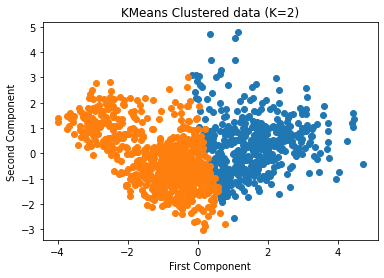

In [17]:
kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(X_proj)
for label in set(labels):
    plt.scatter(X_proj[labels == label, 0], X_proj[labels == label, 1], label=str(label))
    plt.title("KMeans Clustered data (K=2)")
    plt.xlabel("First Component")
    plt.ylabel("Second Component")

Our clustering works! It looks similar to, although slightly more defined, than our original data. This could prove helpful, as it seems that we can potentially fit our clusters to predict the score divisions.

In order to evaluate our clustering, we need to have the true labels. Let's write a function to give the split divisions.

In [18]:
def split_to_divisions(y, divs):
    endpoints = np.linspace(min(y), max(y), divs+1)
    cur = 0
    labels = np.zeros(y.shape)
    for i in range(1, divs+1):
        mask = (y>=endpoints[i-1])&(y<=endpoints[i])
        labels[mask] = cur
        cur+=1
    return labels

In [19]:
split_to_divisions(y,3)

array([2., 2., 2., ..., 0., 0., 0.])

It looks like we have the right clusters. Let's see how it looks.

Text(0, 0.5, 'Second Component')

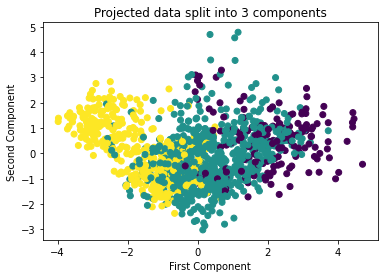

In [20]:
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=split_to_divisions(y,3))
plt.title("Projected data split into 3 components")
plt.xlabel("First Component")
plt.ylabel("Second Component")

Nice! The clusters are clearly grouped by score, following the graphs that we saw earlier. What if we had the PCA divisions side by side with it's decomposition? Let's try it.

In [21]:
def plot_full_divisions(X_proj, y, divs):
    plt.figure().set_size_inches(20,10)
    p = plt.subplot2grid((divs, 2), (0, 0), rowspan=divs, colspan=1)
    labels = split_to_divisions(y,divs)
    for div in set(labels):
        p.scatter(X_proj[labels == div,0], X_proj[labels == div,1], label="Class "+str(div))
    p.set_title("Divisioned projected data")
    p.set_xlabel("First Principle Component")
    p.set_ylabel("Second Principle Component")
    p.legend()
    for i, div in enumerate(set(labels)):
        p = plt.subplot2grid((divs, 2), (i, 1), rowspan=1, colspan=1)
        p.scatter(X_proj[labels == div, 0], X_proj[labels == div, 1], label="Class "+str(div))
        p.set_xlim(X_proj[:,0].min(), X_proj[:,0].max())
        p.set_ylim(X_proj[:,1].min(), X_proj[:,1].max())
        if(i == 0):
            p.set_title("Projected data for labels")
        p.set_xlabel("First Principle Component")
        p.set_ylabel("Second Principle Component")
        p.legend()

3 looked the best before, let's see if we can combine them into a good looking plot.

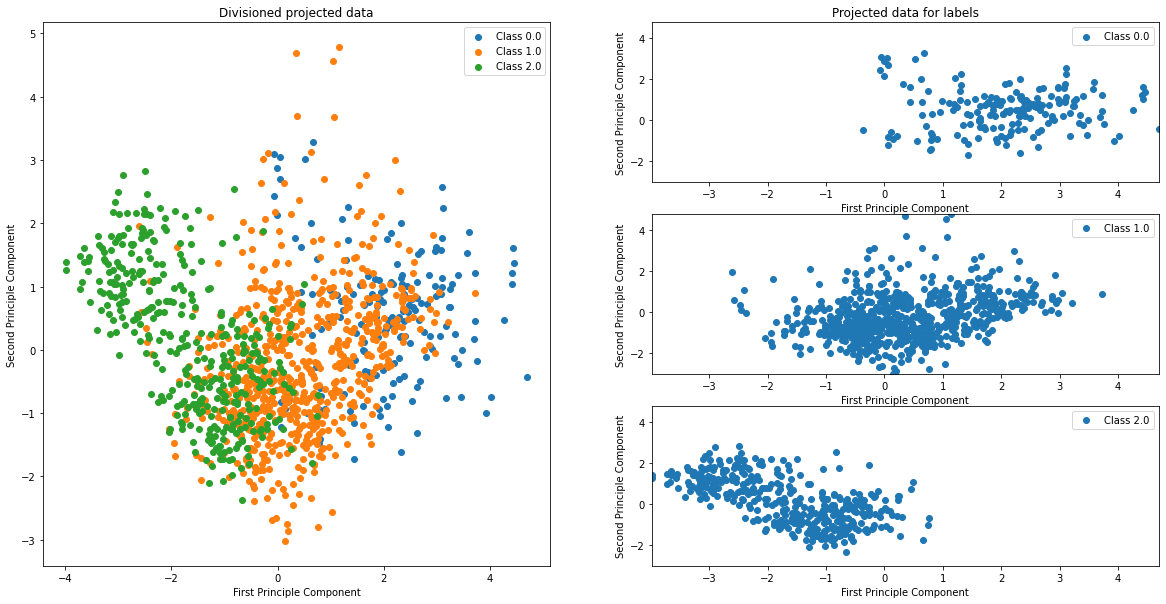

In [22]:
plot_full_divisions(X_proj, y, 3)

Sure enough, it looks like we got the right split. Now, let's compare our predicted KMeans clusters to the true clusters.

In [23]:
y_true = split_to_divisions(y,2)
f1_score(split_to_divisions(y,3), KMeans(3).fit_predict(X), average='micro')

0.2001627339300244

Not a very great score, but still pretty solid. Let's see how the score changes as we increase our K.

Text(0, 0.5, 'f1_score')

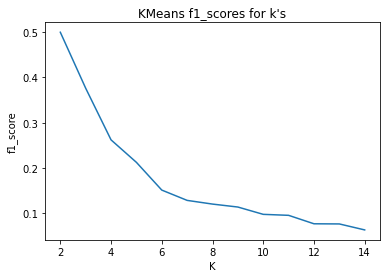

In [24]:
n_clusters = range(2,15)
f1_scores = [np.array([f1_score(split_to_divisions(y,i), KMeans(i).fit_predict(X_proj), average='micro') for _ in range(50)]).mean() for i in n_clusters]
plt.plot(n_clusters, f1_scores)
plt.title("KMeans f1_scores for k's")
plt.xlabel("K")
plt.ylabel("f1_score")


Overall a downward trend, but it still looks like it's getting some of the divisions right. Overall, it follows roughly from what I'd expect, that as we increase the divisions, the data gets split more and more, and more detail is harder to define distinctions for.


## Conclusions


Performing PCA on our dataset allows us to see some trends we normally wouldn't see by summarizing the data. Our PCA components were able to explain roughly 60% of the data, and the projected data follows a trend of having higher scores correlating to lower first component values. The first component vector prioritized GDP and Life Expectancy, while disregarding Generosity and Corruption. When attempting to cluster, we used K-Means, and found a nice looking graph, although it's only marginally better than the expected baseline, so it's unlikely to have a great predictive power.